# Correlation: Hurricane analysis, part 3/3

> * 🔬 Data Science
* 🖥️ Computation-intensive operation, requires GeoAnalytics
* 👟 Ready To Run!

Adapted from the [original sample notebook](https://www.arcgis.com/home/item.html?id=bfe9c45b445b4adbaa3f49d925ef9fdc) published under the same title by Esri in ArcGIS Online.

This is the third part to a three part set of notebooks that process and analyze historic hurricane tracks. In the previous notebooks you completed the following tasks:

**Part 1**
 1. download historic hurricane datasets using Python
 2. clean and merge hurricane observations using Dask
 3. aggregate point observations into hurricane tracks using ArcGIS GeoAnalytics in ArcGIS Pro

**Part 2**
 1. Visualize the locations of hurricane tracks
 2. Analyze different basins and the number of hurricanes per basin
 3. Analyze the number of hurricanes over time
 4. Examine the seasonality in occurrence of hurricanes
 5. Identify places where hurricanes make landfall and the people are affected

In this notebook you will analyze the aggregated tracks to answer important questions about hurricane severity and how the data correlate over time.

*Note: if you would like to skip Parts 1 & 2 of this series, and get started with the analysis in this notebook, you can extract the contents of the `hurricanes.gdb.part2.zip` archive included in the data folder - if a previous copy of `hurricanes.gdb` exists in your data folder, remove it before extracting the data.*

***Disclaimer:*** *the data processing and analyes presented in this notebook are for demonstration purposes only.*

<h1>**Table of Contents**<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Correlation:-Hurricane-analysis,-part-3/3" data-toc-modified-id="Correlation:-Hurricane-analysis,-part-3/3-1">Correlation: Hurricane analysis, part 3/3</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Setup-data-paths" data-toc-modified-id="Setup-data-paths-1.0.1">Setup data paths</a></span></li></ul></li><li><span><a href="#Access-aggregated-hurricane-data" data-toc-modified-id="Access-aggregated-hurricane-data-1.1">Access aggregated hurricane data</a></span><ul class="toc-item"><li><span><a href="#Load-hurricane-tracks-into-a-Spatially-Enabled-DataFrame-and-drop-unneeded-columns" data-toc-modified-id="Load-hurricane-tracks-into-a-Spatially-Enabled-DataFrame-and-drop-unneeded-columns-1.1.1">Load hurricane tracks into a Spatially Enabled <code>DataFrame</code> and drop unneeded columns</a></span></li><li><span><a href="#Load-landfall-tracks-layer-into-a-Spatially-Enabled-DataFrame" data-toc-modified-id="Load-landfall-tracks-layer-into-a-Spatially-Enabled-DataFrame-1.1.2">Load landfall tracks layer into a Spatially Enabled <code>DataFrame</code></a></span></li></ul></li><li><span><a href="#Manage-missing/invalid-sensor-data" data-toc-modified-id="Manage-missing/invalid-sensor-data-1.2">Manage missing/invalid sensor data</a></span><ul class="toc-item"><li><span><a href="#Visualize-missing-records" data-toc-modified-id="Visualize-missing-records-1.2.1">Visualize missing records</a></span></li><li><span><a href="#Missing-value-imputation" data-toc-modified-id="Missing-value-imputation-1.2.2">Missing value imputation</a></span></li></ul></li></ul></li><li><span><a href="#Does-intensity-of-hurricanes-increase-over-time?" data-toc-modified-id="Does-intensity-of-hurricanes-increase-over-time?-2">Does intensity of hurricanes increase over time?</a></span><ul class="toc-item"><li><span><a href="#Does-the-number-of-hurricanes-increase-over-time?" data-toc-modified-id="Does-the-number-of-hurricanes-increase-over-time?-2.1">Does the number of hurricanes increase over time?</a></span></li><li><span><a href="#Does-hurricane-wind-speed-increase-over-time?" data-toc-modified-id="Does-hurricane-wind-speed-increase-over-time?-2.2">Does hurricane wind speed increase over time?</a></span><ul class="toc-item"><li><span><a href="#Analyzing-hurricane-wind-speed-over-time-by-basin" data-toc-modified-id="Analyzing-hurricane-wind-speed-over-time-by-basin-2.2.1">Analyzing hurricane wind speed over time by basin</a></span></li><li><span><a href="#Analyzing-hurricane-category-over-time-by-basin" data-toc-modified-id="Analyzing-hurricane-category-over-time-by-basin-2.2.2">Analyzing hurricane category over time by basin</a></span></li></ul></li><li><span><a href="#Does-eye-pressure-decrease-over-time?" data-toc-modified-id="Does-eye-pressure-decrease-over-time?-2.3">Does eye pressure decrease over time?</a></span></li><li><span><a href="#Do-hurricanes-linger-longer-over-time?" data-toc-modified-id="Do-hurricanes-linger-longer-over-time?-2.4">Do hurricanes linger longer over time?</a></span></li><li><span><a href="#Do-hurricanes-travel-longer-inland-over-time?" data-toc-modified-id="Do-hurricanes-travel-longer-inland-over-time?-2.5">Do hurricanes travel longer inland over time?</a></span></li><li><span><a href="#Correlate-observations-over-time" data-toc-modified-id="Correlate-observations-over-time-2.6">Correlate observations over time</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2.7">Conclusion</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#References" data-toc-modified-id="References-2.7.0.1">References</a></span></li></ul></li></ul></li></ul></li></ul></div>

Import the libraries necessary for this notebook.

In [1]:
# import ArcGIS Libraries
import arcpy
from arcgis.geometry import filters
from arcgis.geocoding import geocode
from arcgis.features.manage_data import overlay_layers

# import Pandas for data exploration
import pandas as pd
import numpy as np
from scipy import stats

# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# import display tools
from pprint import pprint
from IPython.display import display

# import system libs
from sys import getsizeof

# Miscellaneous imports
import os
import warnings
warnings.filterwarnings('ignore')

### Setup data paths

*Note: update the `data_dir` path to point to the location where you extracted the files for this workshop.*

In [2]:
data_dir = 'D:/arcgis_notebooks/hurricane_analysis/data'
hurricanes_gdb = os.path.join(data_dir, "hurricanes.gdb")

## Access aggregated hurricane data
Below, you will access the tracks that were aggregated using GeoAnalytics tools in ArcGIS Pro in Part 1 of this notebook series.

In [3]:
hurricane_tracks_fc = os.path.join(hurricanes_gdb, "hurricane_tracks")

The **GeoAnalytics** reconstruct tracks tools was used to calculate summary statistics of all numeric fields. However, only a few of the resulting columns are of interest for this tutorial.

In [4]:
pprint([f.name for f in arcpy.Describe(hurricane_tracks_fc).fields], compact=True, width=80)

OSError: "D:/arcgis_notebooks/hurricane_analysis/data\hurricanes.gdb\hurricane_tracks" does not exist

Below you will specify list of the names of fields that need to be kept for the rest of the analysis in this notebook.

In [ ]:
fields_to_keep = ['OBJECTID', 'COUNT', 'MIN_Season', 'ANY_Basin', 'ANY_Sub_basin',
                  'ANY_Name', 'MEAN_latitude_merged', 'MEAN_longitude_merged',
                  'MAX_wind_merged', 'RANGE_wind_merged', 'MIN_pressure_merged',
                  'RANGE_pressure_merged', 'MAX_eye_dia_merged', 'TRACK_DURATION',
                  'END_DATE', 'START_DATE']

fields_to_drop = [
    f.name for f in arcpy.Describe(hurricane_tracks_fc).fields if f.name not in fields_to_keep 
    and not f.name.lower().startswith("shape")
]

### Load hurricane tracks into a Spatially Enabled `DataFrame` and drop unneeded columns

Using the ArcGIS API for Python, load the tracks feature class into a new spatially enabled data frame:

In [ ]:
hurricane_tracks_sdf = pd.DataFrame.spatial.from_featureclass(hurricane_tracks_fc)

Select only the columns listed in `fields_to_keep`

In [ ]:
hurricane_tracks_sdf.drop(labels=fields_to_drop, axis=1, inplace=True)
hurricane_tracks_sdf.shape

(12757, 17)

There are **`12,757`** hurricanes identified by GeoAnalytics aggregate tracks tool. To get an idea about this aggregated dataset, call the `head()` method.

In [ ]:
hurricane_tracks_sdf.head()

,OBJECTID,COUNT,MIN_Season,ANY_Basin,ANY_Sub_basin,ANY_Name,MEAN_latitude_merged,MEAN_longitude_merged,MAX_wind_merged,RANGE_wind_merged,MIN_pressure_merged,RANGE_pressure_merged,MAX_eye_dia_merged,TRACK_DURATION,START_DATE,END_DATE,SHAPE
0,1,21.0,1848,SI,MM,XXXX848002,-24.045952,51.730714,0.0,0.0,0.0,0.0,NaN,432000000.0,1848-01-12 18:00:00,1848-01-17 18:00:00,"{""paths"": [[[57.400000000000034, -15.199999999..."
1,2,7.0,1854,SI,MM,NOT NAMED,-19.318571,60.639286,NaN,NaN,NaN,NaN,NaN,129600000.0,1854-02-08 06:00:00,1854-02-10 18:00:00,"{""paths"": [[[59.60000000000008, -17.5999999999..."
2,3,13.0,1854,SI,MM,XXXX854011,-17.511538,69.167692,0.0,0.0,0.0,0.0,NaN,259200000.0,1854-03-02 18:00:00,1854-03-05 18:00:00,"{""paths"": [[[69.00000000000006, -15.2999999999..."
3,4,43.0,1854,NA,NA,UNNAMED,30.895349,-70.434884,110.0,75.0,0.0,950.0,0.0,885600000.0,1854-09-03 12:00:00,1854-09-13 06:00:00,"{""paths"": [[[-59.799999999999955, 24.500000000..."
4,5,12.0,1854,NA,NA,UNNAMED,29.841667,-65.300000,60.0,10.0,0.0,0.0,0.0,237600000.0,1854-10-20 00:00:00,1854-10-23 06:00:00,"{""paths"": [[[-67.59999999999997, 25.0000000000..."


To better analyze this data set over time, ensure the `START_DATE` and `END_DATE` columns are converted to datetime objects.  The `START_DATE` column will also be set as the index of the dataset, and the records will be sorted in chronological order.

In [ ]:
hurricane_tracks_sdf['START_DATE'] = pd.to_datetime(hurricane_tracks_sdf['START_DATE'])
hurricane_tracks_sdf['END_DATE'] = pd.to_datetime(hurricane_tracks_sdf['END_DATE'])
hurricane_tracks_sdf.index = hurricane_tracks_sdf['START_DATE']
hurricane_tracks_sdf.sort_index(inplace=True)
hurricane_tracks_sdf.head()

,OBJECTID,COUNT,MIN_Season,ANY_Basin,ANY_Sub_basin,ANY_Name,MEAN_latitude_merged,MEAN_longitude_merged,MAX_wind_merged,RANGE_wind_merged,MIN_pressure_merged,RANGE_pressure_merged,MAX_eye_dia_merged,TRACK_DURATION,START_DATE,END_DATE,SHAPE
START_DATE,,,,,,,,,,,,,,,,,
1842-10-26 18:00:00,4795,33.0,1842,NI,BB,NOT NAMED,12.004697,67.431061,NaN,NaN,NaN,NaN,NaN,691200000.0,1842-10-26 18:00:00,1842-11-03 18:00:00,"{""paths"": [[[79.81500000000005, 10.88500000000..."
1845-12-03 18:00:00,11181,13.0,1845,NI,AS,NOT NAMED,11.537308,72.448846,NaN,NaN,NaN,NaN,NaN,259200000.0,1845-12-03 18:00:00,1845-12-06 18:00:00,"{""paths"": [[[74.17500000000007, 10.01500000000..."
1848-01-12 18:00:00,1,21.0,1848,SI,MM,XXXX848002,-24.045952,51.730714,0.0,0.0,0.0,0.0,NaN,432000000.0,1848-01-12 18:00:00,1848-01-17 18:00:00,"{""paths"": [[[57.400000000000034, -15.199999999..."
1848-01-12 18:00:00,11988,9.0,1848,SI,MM,NOT NAMED,-25.063889,50.366667,NaN,NaN,NaN,NaN,NaN,172800000.0,1848-01-12 18:00:00,1848-01-14 18:00:00,"{""paths"": [[[56.80000000000007, -15.7999999999..."
1848-01-12 18:00:00,787,45.0,1848,SI,MM,XXXX848003,-16.966778,72.083222,0.0,0.0,0.0,0.0,NaN,950400000.0,1848-01-12 18:00:00,1848-01-23 18:00:00,"{""paths"": [[[79.80000000000007, -8.59999999999..."


The track duration columns can be represented in units (days, hours) that are more meaningful for analysis.

In [ ]:
hurricane_tracks_sdf['TRACK_DURATION_HRS'] = hurricane_tracks_sdf['TRACK_DURATION'] / 3600000
hurricane_tracks_sdf['TRACK_DURATION_DAYS'] = hurricane_tracks_sdf['TRACK_DURATION'] / (3600000*24)

### Load landfall tracks layer into a Spatially Enabled `DataFrame`
Load the landfall tracks layer created in Part 2 of this notebook series into a spatially enabled data frame, and retain only the columns needed for the analysis in this tutorial.

In [ ]:
hurricane_landfall_tracks_fc = os.path.join(hurricanes_gdb, "hurricane_landfall_tracks")


fields_to_keep = ['MIN_Season', 'ANY_Basin','ANY_Name', 'MAX_wind_merged', 
                  'MIN_pressure_merged', 'TRACK_DURATION','END_DATE', 
                  'START_DATE', 'ANALYSIS_LENGTH']

fields_to_drop = [
    f.name for f in arcpy.Describe(hurricane_landfall_tracks_fc).fields if f.name not in fields_to_keep 
    and not f.name.lower().startswith("shape")
]

hurricane_landfall_tracks_sdf = pd.DataFrame.spatial.from_featureclass(hurricane_landfall_tracks_fc)
hurricane_landfall_tracks_sdf.drop(labels=fields_to_drop, axis=1, inplace=True)
hurricane_landfall_tracks_sdf.head()

,MIN_Season,ANY_Basin,ANY_Name,MAX_wind_merged,MIN_pressure_merged,TRACK_DURATION,START_DATE,END_DATE,Shape_Length_overlay,ANALYSIS_LENGTH,SHAPE
0,1944,NI,NOT NAMED,30.0,NaN,280800000.0,1944-09-29 00:00:00,1944-10-02 06:00:00,3.111768e+08,950.412881,"{""paths"": [[[86.74735001800008, 20.48009201400..."
1,1960,WP,NOT NAMED,NaN,NaN,216000000.0,1960-11-26 12:00:00,1960-11-29 00:00:00,3.111768e+08,105.069954,"{""paths"": [[[100.07389036200004, 9.51444435900..."
2,1967,SP,19P:BARBARA,45.0,987.0,432000000.0,1967-02-17 00:00:00,1967-02-22 00:00:00,2.996954e+07,121.064800,"{""paths"": [[[153.57291462800004, -28.590155667..."
3,1909,SP,NOT NAMED,NaN,NaN,388800000.0,1909-03-10 12:00:00,1909-03-15 00:00:00,2.996954e+07,639.210056,"{""paths"": [[[134.18654860000004, -12.039216963..."
4,2007,NA,CHANTAL,60.0,964.0,475200000.0,2007-07-31 00:00:00,2007-08-05 12:00:00,5.951525e+08,44.465425,"{""paths"": [[[-53.325529133999964, 46.704682519..."


## Manage missing/invalid sensor data
Before you can analyze if hurricanes intensify over time, you need to identify and account for missing values in the data. Sensor measurements such as **wind speed**, **atmospheric pressure**, **eye diameter**, generally suffer from missing values and outliers.

First, you will remove values that are known to be invalid - for example wind speed in a hurricane should never be zero or below zero, and pressure values below 800mb are [unrealistic](https://en.wikipedia.org/wiki/Hurricane_Wilma#Records_and_naming).

Execute the following cell to substitute these invalid values with `NaN` (a non-numerical value recognized as missing data in a Pandas `DataFrame`).

In [ ]:
a = np.array(hurricane_tracks_sdf["MAX_wind_merged"].values.tolist())
hurricane_tracks_sdf["MAX_wind_merged"] = np.where(a <= 0, np.NaN, a).tolist()

a = np.array(hurricane_tracks_sdf["MIN_pressure_merged"].values.tolist())
hurricane_tracks_sdf["MIN_pressure_merged"] = np.where(a < 800, np.NaN, a).tolist()

a = np.array(hurricane_tracks_sdf["MAX_eye_dia_merged"].values.tolist())
hurricane_tracks_sdf["MAX_eye_dia_merged"] = np.where(a <= 0, np.NaN, a).tolist()

### Visualize missing records
An easy way to visualize missing records is to hack the `heatmap` of the `seaborn` library to display missing records.

Execute the code cell below to show missing records highlighted in **yellow**.

Text(0.5, 1.0, 'Missing values (yellow) vizualized as a heatmap')

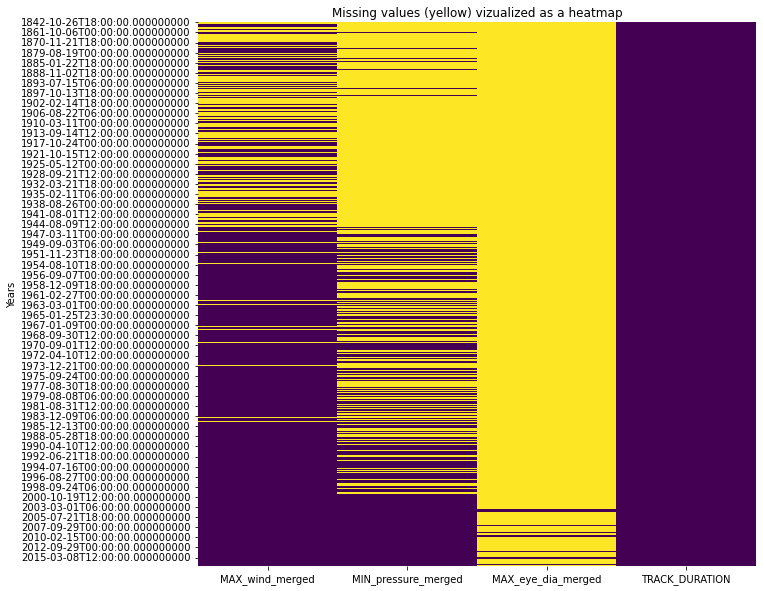

In [ ]:
missing_data_viz = hurricane_tracks_sdf.copy()

for column in hurricane_tracks_sdf.columns:
    if column == "SHAPE":
        continue
    if column == "MIN_pressure_merged":
        missing_data_viz['MIN_pressure_merged'] = missing_data_viz['MIN_pressure_merged'].replace(100.0,np.NaN)
    else:
        missing_data_viz[column] = missing_data_viz[column].replace(0, np.NaN)

plt.figure(figsize=(10,10))
missing_data_ax = sns.heatmap(missing_data_viz[['MAX_wind_merged', 'MIN_pressure_merged',
                                                'MAX_eye_dia_merged', 'TRACK_DURATION']].isnull(),
                              cbar=False, cmap='viridis')
missing_data_ax.set_ylabel('Years')
missing_data_ax.set_title('Missing values (yellow) vizualized as a heatmap')

You can see that all three observation columns for wind speed, atmospheric pressure, and eye diameter suffer from missing values. In general, as technology has improved over time, better data were collected with fewer missing observations. In the sections below, you will attempt to fill these values using different techniques. You will compare how they fare, and pick one of them for rest of the analysis.

### Missing value imputation

**Technique 1: Drop missing values**:
An easy way to deal with missing values is to drop those record from analysis. If you do that for wind and pressure, you will lose more than half of the hurricane tracks (almost all are removed if this method is applied to the eye diameter column).

In [ ]:
hurricanes_nona = missing_data_viz.dropna(subset=['MAX_wind_merged','MIN_pressure_merged'])
hurricanes_nona.shape

(4935, 19)

**Technique 2: Fill using median value**:
A common technique is to fill using median value (or a different measure of centrality). This technique computes the median of the entire column and applies that to all the missing values.

In [ ]:
fill_values = {'MAX_wind_merged': missing_data_viz['MAX_wind_merged'].median(),
               'MIN_pressure_merged': missing_data_viz['MIN_pressure_merged'].median(),
               'TRACK_DURATION_HRS': missing_data_viz['TRACK_DURATION_HRS'].median()}
hurricanes_fillna = missing_data_viz.copy().fillna(value=fill_values)

**Technique 3: Fill by interpolating between existing values**: A more sophisticated approach is to interploate a missing value based on two of its closest observations.

In [ ]:
hurricanes_ipl = missing_data_viz.copy()
hurricanes_ipl['MAX_wind_merged'] = hurricanes_ipl['MAX_wind_merged'].interpolate()
hurricanes_ipl['MIN_pressure_merged'] = hurricanes_ipl['MIN_pressure_merged'].interpolate()
hurricanes_ipl['TRACK_DURATION_HRS'] = hurricanes_ipl['TRACK_DURATION_HRS'].interpolate()

**Visualize all 3 techniques**

To compare how each of these techniques fared, execute the following cell to plot a histogram of the **wind speed** column for each method of addressing missing values.

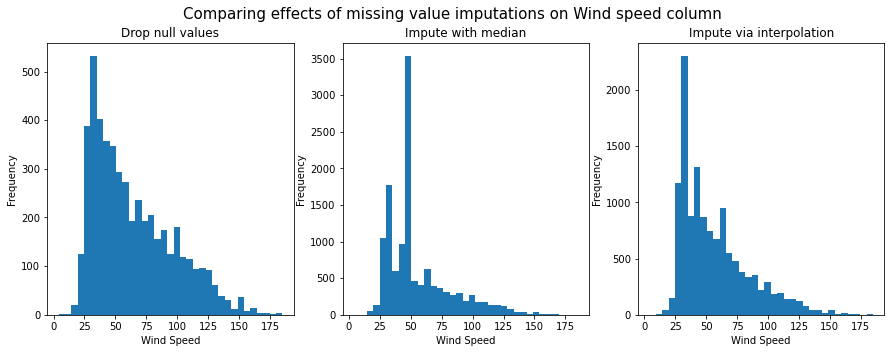

In [ ]:
fig, ax = plt.subplots(1,3, sharex=True, figsize=(15,5))
fig.suptitle('Comparing effects of missing value imputations on Wind speed column', 
             fontsize=15)

hurricanes_nona['MAX_wind_merged'].plot(kind='hist', ax=ax[0], bins=35, title='Drop null values')
hurricanes_fillna['MAX_wind_merged'].plot(kind='hist', ax=ax[1], bins=35, title='Impute with median')
hurricanes_ipl['MAX_wind_merged'].plot(kind='hist', ax=ax[2], bins=35, title='Impute via interpolation')
for a in ax:
    a.set_xlabel('Wind Speed')

Next, plot the histogram of **atmospheric pressure** column after accounting for missing values.

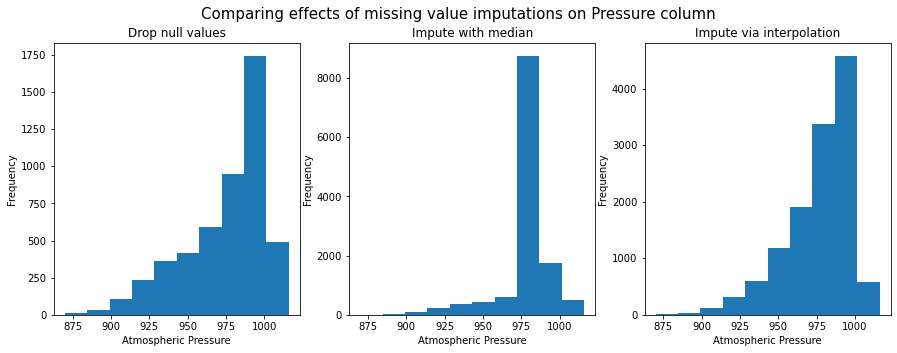

In [ ]:
fig, ax = plt.subplots(1,3, sharex=True, figsize=(15,5))
fig.suptitle('Comparing effects of missing value imputations on Pressure column', 
             fontsize=15)

hurricanes_nona['MIN_pressure_merged'].plot(kind='hist', ax=ax[0], title='Drop null values')
hurricanes_fillna['MIN_pressure_merged'].plot(kind='hist', ax=ax[1], title='Impute with median')
hurricanes_ipl['MIN_pressure_merged'].plot(kind='hist', ax=ax[2], title='Impute via interpolation')
for a in ax:
    a.set_xlabel('Atmospheric Pressure')

**Fill using interpolation preserves the shape** of the original distributions.

You will use these for further anlaysis.

# Does intensity of hurricanes increase over time?
This last part of the tutorial analyzes if there is a temporal trend in the intensity of hurricanes. A number of studies have concluded that anthropogenic influences in the form of global climate change make hurricanes worse and dangerous. You will analyze if such patterns can be noticed from an empirical standpoint with the `176` years of hurricane data you have prepared.

## Does the number of hurricanes increase over time?

Text(0.5, 1.0, 'Number of hurricanes per season')

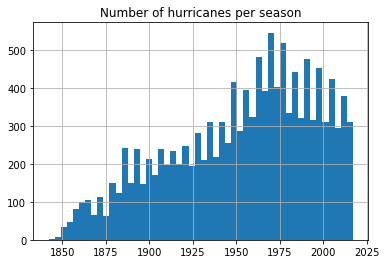

In [ ]:
ax = hurricane_tracks_sdf['MIN_Season'].hist(bins=50)
ax.set_title('Number of hurricanes per season')

From the previous notebook, you will recall that the number of hurricanes recorded has been steadily increasing.  This is likely due to advancements in technology for tracking storms. However, you have also noticed a reduction in frequency over time since the 1970s.

Execute the cell below to split this up by basin and observe if the trend is similar.

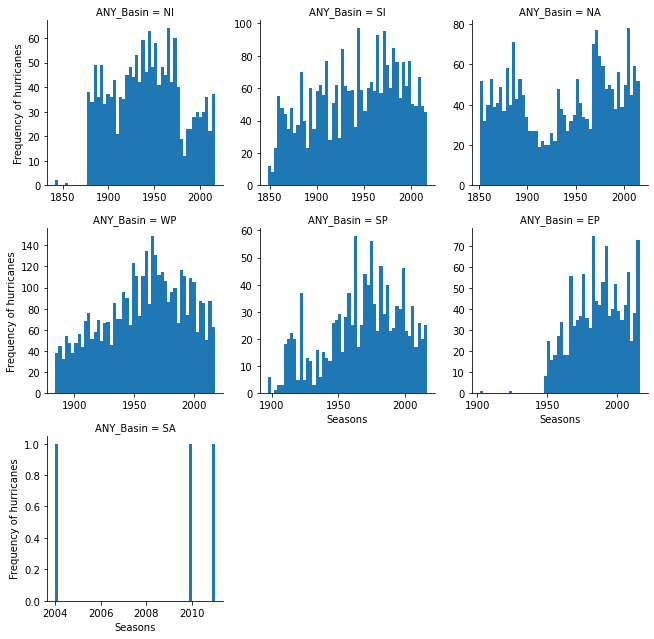

In [ ]:
fgrid = sns.FacetGrid(data=hurricane_tracks_sdf, col='ANY_Basin', col_wrap=3, sharex=False, sharey=False)
fgrid.map(plt.hist, 'MIN_Season', bins=50)
fgrid.set_axis_labels(x_var='Seasons', y_var='Frequency of hurricanes')

Plotting the frequency of hurricanes by basin shows a general trend of the number of hurricanes reducing globally after 1970s. [This is consistent with certain studies (1)](https://link.springer.com/epdf/10.1007/s00382-013-1713-0?shared_access_token=cHh_-kXbFWgMacxvFkMyWPe4RwlQNchNByi7wbcMAY65lj3v5VSTqd8rbUj9HyyFUZS9H0Z0WdJn6EgG-Onhfk9U48b6jvTjrJTuMH8OuGbT6R1Y54MGaHwYq2EEp6ppcoACaJgdWo3v3VtPDcq9Whm0MUw98Z4wCFy7jbwwcY4%3D). However, this is only one part of the story. Below, you will continue bo analyze whether the nature of hurricanes itself is changing, while the total number may be reducing.

## Does hurricane wind speed increase over time?
To understand if wind speed increases over time, create a scatter plot of `MIN_Season` against the `MAX_wind_merged` column. The `seaborn` plotting library can enhance this plot with a **correlation coefficient** and its level of signifance (**p value**).

In [ ]:
def get_pearsonr(df, col1, col2):
    no_na = df[[col1, col2]].dropna()
    return stats.pearsonr(no_na[col1], no_na[col2])

In [ ]:
hurricanes_ipl[hurricanes_ipl.index.duplicated(keep=False)]

,OBJECTID,COUNT,MIN_Season,ANY_Basin,ANY_Sub_basin,ANY_Name,MEAN_latitude_merged,MEAN_longitude_merged,MAX_wind_merged,RANGE_wind_merged,MIN_pressure_merged,RANGE_pressure_merged,MAX_eye_dia_merged,TRACK_DURATION,START_DATE,END_DATE,SHAPE,TRACK_DURATION_HRS,TRACK_DURATION_DAYS
START_DATE,,,,,,,,,,,,,,,,,,,
1848-01-12 18:00:00,1,21.0,1848,SI,MM,XXXX848002,-24.045952,51.730714,NaN,NaN,NaN,NaN,NaN,4.320000e+08,1848-01-12 18:00:00,1848-01-17 18:00:00,"{""paths"": [[[57.400000000000034, -15.199999999...",120.0,5.00
1848-01-12 18:00:00,11988,9.0,1848,SI,MM,NOT NAMED,-25.063889,50.366667,NaN,NaN,NaN,NaN,NaN,1.728000e+08,1848-01-12 18:00:00,1848-01-14 18:00:00,"{""paths"": [[[56.80000000000007, -15.7999999999...",48.0,2.00
1848-01-12 18:00:00,787,45.0,1848,SI,MM,XXXX848003,-16.966778,72.083222,NaN,NaN,NaN,NaN,NaN,9.504000e+08,1848-01-12 18:00:00,1848-01-23 18:00:00,"{""paths"": [[[79.80000000000007, -8.59999999999...",264.0,11.00
1848-01-12 18:00:00,8836,25.0,1848,SI,MM,NOT NAMED,-16.139600,70.514000,NaN,NaN,NaN,NaN,NaN,5.184000e+08,1848-01-12 18:00:00,1848-01-18 18:00:00,"{""paths"": [[[79.00000000000006, -8.99999999999...",144.0,6.00
1851-03-21 06:00:00,8019,23.0,1851,SI,MM,NOT NAMED,-17.139565,56.117174,NaN,NaN,NaN,NaN,NaN,4.752000e+08,1851-03-21 06:00:00,1851-03-27 18:00:00,"{""paths"": [[[62.400000000000034, -14.999999999...",132.0,5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-16 18:00:00,783,35.0,2016,WP,MM,MINDULLE,27.828857,141.161000,65.0,65.0,975.0,32.0,NaN,5.616000e+08,2016-08-16 18:00:00,2016-08-23 06:00:00,"{""paths"": [[[138.10000000000002, 15.4000000000...",156.0,6.50
2016-08-16 18:00:00,5565,31.0,2016,NA,NA,FIONA,20.032258,-48.925806,45.0,25.0,1004.0,12.0,NaN,6.480000e+08,2016-08-16 18:00:00,2016-08-24 06:00:00,"{""paths"": [[[-32.19999999999993, 12.0000000000...",180.0,7.50
2016-08-16 18:00:00,5566,62.0,2016,WP,MM,LIONROCK,29.413306,138.936129,95.0,95.0,940.0,67.0,25.0,1.209600e+09,2016-08-16 18:00:00,2016-08-30 18:00:00,"{""paths"": [[[160.20000000000005, 25.0000000000...",336.0,14.00


Text(0.5, 1.0, 'Does hurricane wind speed increase over time?')

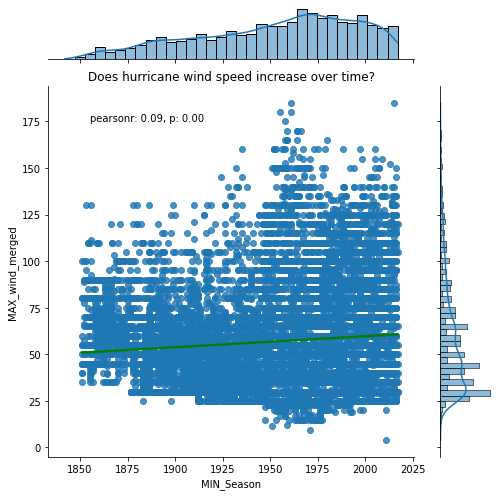

In [ ]:
jgrid = sns.jointplot(x='MIN_Season', y='MAX_wind_merged', data=hurricanes_ipl.reset_index(drop=True),
             kind='reg', joint_kws={'line_kws':{'color':'green'}}, height=7, space=0.5)

r, p = get_pearsonr(hurricanes_ipl, 'MIN_Season', 'MAX_wind_merged')

jgrid.ax_joint.text(x=1855, y=175, s="pearsonr: {:.2f}, p: {:.2f}".format(r, p))

jgrid.ax_joint.set_title('Does hurricane wind speed increase over time?')

From the plot above, you will notice a small positive correlation. Wind speeds are observed to increase with time. The small `p-value` suggests this correlation (albeit small) is **statistically significant**. The plot above considers hurricanes across all the basins and regresses that against time. To get a finer picture, you will **split the data by basins** and observe the correlation.

Since there are not many hurricanes observed over South Atlantic basin (SA), you will drop it from the remaining analysis:

In [ ]:
hurricanes_major_basins_df = hurricanes_ipl[hurricanes_ipl['ANY_Basin'].isin(['WP','SI','NA','EP','NI','SP'])]

Execute the cell below to define a function that can compute `pearson-r` correlation coefficient for any two columns across all basins - this will be used several times through the rest of this notebook.

In [ ]:
def correlate_by_basin(column_a, column_b, df=hurricanes_major_basins_df, category_column = 'ANY_Basin'):
    # clean data by dropping any NaN values
    df_nona = df.dropna(subset=[column_a, column_b])
    
    # loop through the basins
    basins = list(df[category_column].unique())
    return_dict = {}
    for basin in basins:
        subset_df = df_nona[df_nona[category_column] == basin]
        r, p = stats.pearsonr(list(subset_df[column_a]), list(subset_df[column_b]))
        
        return_dict[basin] = [round(r,4), round(p,4)]
    
    # return correlation coefficient and p-value for each basin as a DataFrame
    return_df = pd.DataFrame(return_dict).T
    return_df.columns=['pearson-r','p-value']
    return return_df

### Analyzing hurricane wind speed over time by basin
Below you will produce a grid of scatter plots with linear regression plots overlaid over them. The `seaborn` library's `lmplot()` function makes it trivial to accomplish this in a single command.

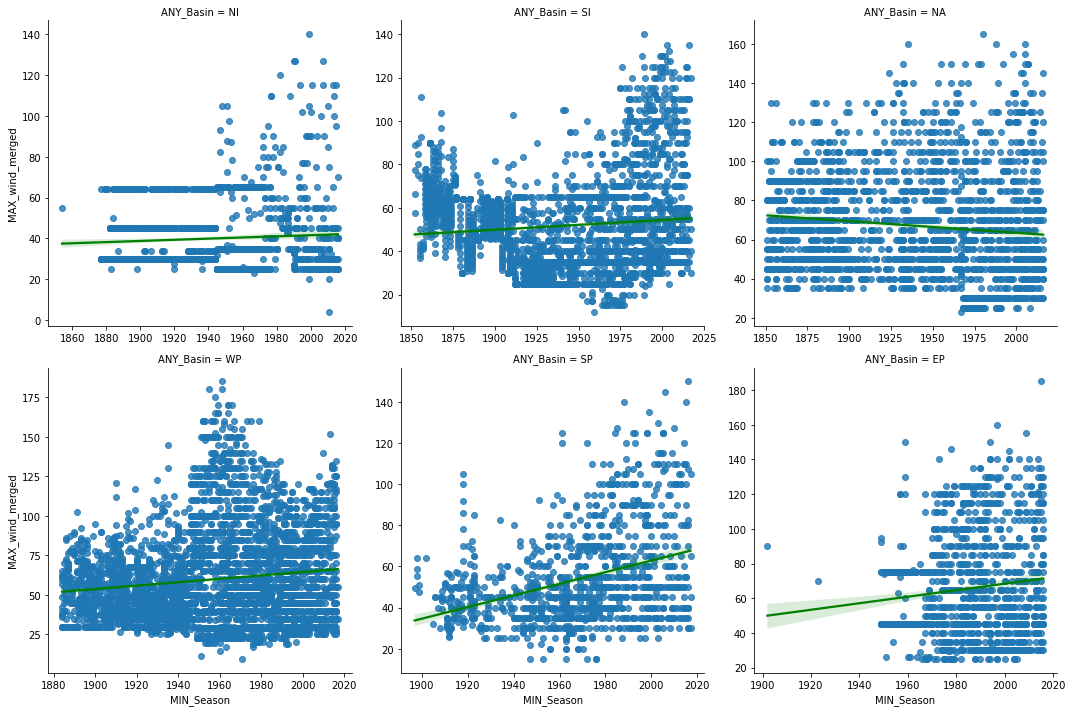

In [ ]:
fgrid = sns.lmplot('MIN_Season', 'MAX_wind_merged', col='ANY_Basin', 
                   data=hurricanes_major_basins_df, col_wrap=3,
                   sharex=False, sharey=False, line_kws={'color':'green'})

From the scatter plots above, you will notice the wind speeds in most basins show a slight positive trend, with **North Atlantic** being an exception. To explore this further, compute the correlation coefficient and its p-value below for each basin, using the `correlate_by_basin` function you defined earlier.

In [ ]:
wind_corr_df = correlate_by_basin('MIN_Season','MAX_wind_merged')
print('Correlation coefficients for MIN_Season vs MAX_wind_merged')
wind_corr_df

Correlation coefficients for MIN_Season vs MAX_wind_merged


,pearson-r,p-value
NI,0.0617,0.0142
SI,0.0895,0.0000
NA,-0.1075,0.0000
WP,0.1210,0.0000
SP,0.3519,0.0000
EP,0.1114,0.0001


The table above displays the correlation coefficient of hurricane wind speed over time. Hurricanes over the **Southern Pacific** basin exhibit a positive trend of increasing wind speeds. The `r` value over the **North Atlantic** shows a weak negative trend. All results have a `p-value` less than `0.05`, indicating statistically significant results.

### Analyzing hurricane category over time by basin
Hurricanes are classified on a [Saffir-Simpson](https://www.nhc.noaa.gov/aboutsshws.php) scale of `1-5` based on their wind speed. Execute the cells to define a function that categorizes wind speeds, and then use that to compute a column with this classification for the dataset so that you can analyze if there are temporal aspects to it.

In [ ]:
def categorize_hurricanes(row, wind_speed_column='MAX_wind_merged'):
    wind_speed = row[wind_speed_column] * 1.152  # knots to mph
    if 74 <= wind_speed <= 95:
        return '1'
    elif 96 <= wind_speed <= 110:
        return '2'
    elif 111 <= wind_speed <= 129:
        return '3'
    elif 130 <= wind_speed <= 156:
        return '4'
    elif 157 <= wind_speed <= 500:
        return '5'

In [ ]:
hurricanes_major_basins_df['category_str'] = hurricanes_major_basins_df.apply(categorize_hurricanes, axis=1)
hurricanes_major_basins_df['category'] = pd.to_numeric(arg=hurricanes_major_basins_df['category_str'],
                                                       errors='coerce', downcast='integer')

hurricanes_major_basins_df.head(2)

,OBJECTID,COUNT,MIN_Season,ANY_Basin,ANY_Sub_basin,ANY_Name,MEAN_latitude_merged,MEAN_longitude_merged,MAX_wind_merged,RANGE_wind_merged,...,RANGE_pressure_merged,MAX_eye_dia_merged,TRACK_DURATION,START_DATE,END_DATE,SHAPE,TRACK_DURATION_HRS,TRACK_DURATION_DAYS,category_str,category
START_DATE,,,,,,,,,,,,,,,,,,,,,
1842-10-26 18:00:00,4795,33.0,1842,NI,BB,NOT NAMED,12.004697,67.431061,NaN,NaN,...,NaN,NaN,691200000.0,1842-10-26 18:00:00,1842-11-03 18:00:00,"{""paths"": [[[79.81500000000005, 10.88500000000...",192.0,8.0,None,NaN
1845-12-03 18:00:00,11181,13.0,1845,NI,AS,NOT NAMED,11.537308,72.448846,NaN,NaN,...,NaN,NaN,259200000.0,1845-12-03 18:00:00,1845-12-06 18:00:00,"{""paths"": [[[74.17500000000007, 10.01500000000...",72.0,3.0,None,NaN


Below you will create violin and bar plots to visualize the number of hurricane categories over different basins.

Text(0.5, 1.0, 'Number of hurricanes per category in each basin')

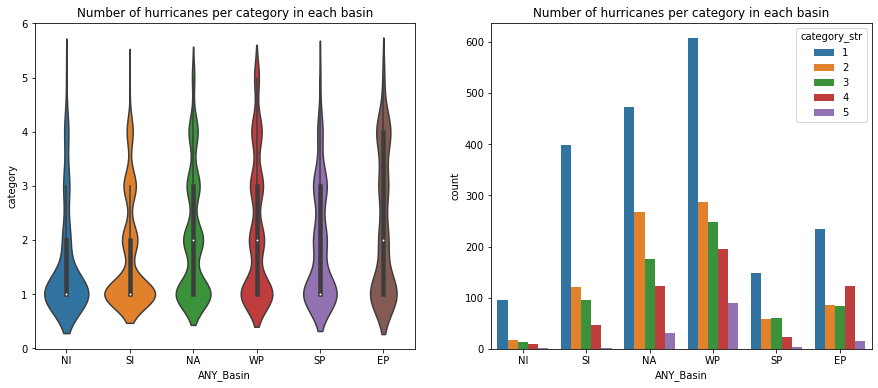

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
vplot = sns.violinplot(x='ANY_Basin', y='category', data=hurricanes_major_basins_df, ax=ax[0])
vplot.set_title('Number of hurricanes per category in each basin')

cplot = sns.countplot(x='ANY_Basin', hue='category_str', data=hurricanes_major_basins_df,
             hue_order=['1','2','3','4','5'], ax=ax[1])
cplot.set_title('Number of hurricanes per category in each basin')

Notice that all basins are capable of generating major hurricanes (over category 3). The **Eastern Pacific** basin appears to have a proportionally high number of major hurricanes.

Below, you will regress the hurricane category against time to observe if there is a positive trend.

Text(1830, 5.8, 'Scatter plot of hurricane categories over seasons')

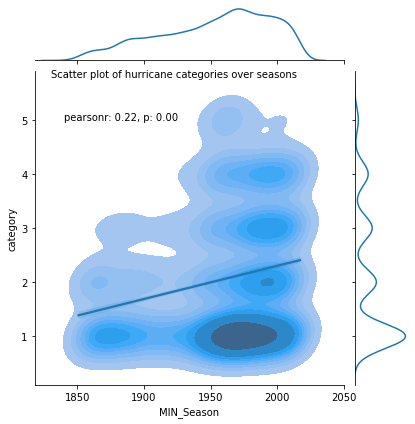

In [ ]:
kde_regplot = sns.jointplot(
    x='MIN_Season', y='category', data=hurricanes_major_basins_df.reset_index(drop=True), kind='kde', shade=True
).plot_joint(sns.regplot, scatter=False)

r, p = get_pearsonr(hurricanes_major_basins_df, 'MIN_Season', 'category')

kde_regplot.ax_joint.text(x=1840, y=5, s="pearsonr: {:.2f}, p: {:.2f}".format(r, p))

kde_regplot.ax_joint.text(x=1830, y=5.8, s='Scatter plot of hurricane categories over seasons')

Even at a global level, there appears to be a strong positive correlation between hurricane category and seasons. Below, you will split this across basins to observe if the trend holds well regionally.

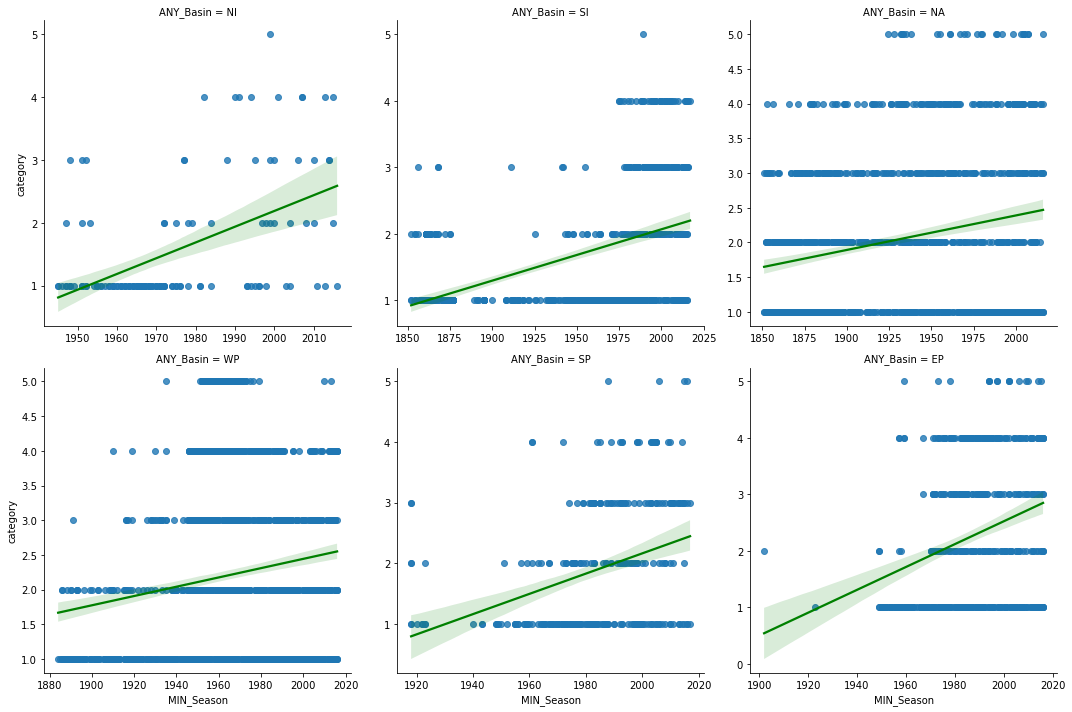

In [ ]:
wgrid = sns.lmplot('MIN_Season', 'category', col='ANY_Basin', 
                   data=hurricanes_major_basins_df, col_wrap=3,
                   sharex=False, sharey=False, line_kws={'color':'green'})

Compute the correlation coefficient and its p-value below for each basin, using the `correlate_by_basin` function.

In [ ]:
category_corr_df = correlate_by_basin('MIN_Season','category')
print('Correlation coefficients for MIN_Season vs hurricane category')
category_corr_df

Correlation coefficients for MIN_Season vs hurricane category


,pearson-r,p-value
NI,0.5085,0.0
SI,0.4185,0.0
NA,0.2185,0.0
WP,0.1627,0.0
SP,0.3399,0.0
EP,0.2875,0.0


At both global and basin scales, you can see a significant **positive trend in the number of hurricanes of category `4` and higher**, while there is a general reduction in the quantity of hurricanes per season. This is along the lines of several studies [[1]](https://doi.org/10.1007/s00382-013-1713-0) [[2]](https://bankunderground.co.uk/2018/05/22/us-hurricane-clustering-a-new-reality/) [[3]](https://www.nature.com/articles/nature03906) [[4]](https://www.nytimes.com/2018/10/10/climate/hurricane-michael-climate-change.html). Thus, while the total number of hurricanes per season may be declining, they are increasing in intensity.

## Does eye pressure decrease over time?
Just like a high wind speed, lower atmospheric pressure increases the intensity of hurricanes. To analyze this, execute the cell below to produce a scatter grid of `MIN_pressure_merged` column and regress it against `MIN_Season` column, split by basins.

***Note:*** *because the available data for eye pressure are extremely sparse prior to about 1950, the interpolation used to fill missing data has created noticeable patterns visible in the plots generated below.  You could try performing the same analysis in the two following cells by filtering rows from `hurricanes_major_basins_df` to only those with a `MIN_Season` greater than or equal to `1950`, or use the `hurricanes_nona` data frame to use all valid data points without imputed values.*

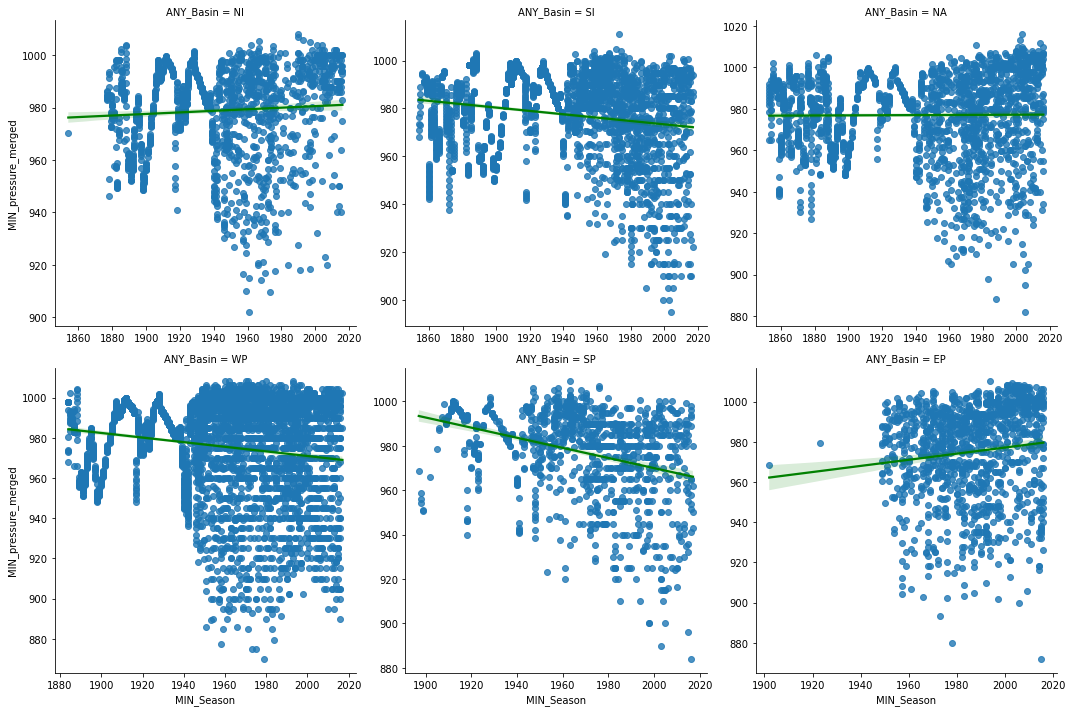

In [ ]:
pgrid = sns.lmplot('MIN_Season', 'MIN_pressure_merged', col='ANY_Basin', 
                   data=hurricanes_major_basins_df, col_wrap=3,
                   sharex=False, sharey=False, line_kws={'color':'green'})

Compute the correlation coefficient and its p-value below for each basin, using the `correlate_by_basin` function.

In [ ]:
pressure_corr_df = correlate_by_basin('MIN_Season','MIN_pressure_merged', df=hurricanes_major_basins_df)
print('Correlation coefficients for MIN_Season vs MIN_pressure_merged')
pressure_corr_df

Correlation coefficients for MIN_Season vs MIN_pressure_merged


,pearson-r,p-value
NI,0.0620,0.0136
SI,-0.1679,0.0000
NA,0.0074,0.7343
WP,-0.1581,0.0000
SP,-0.3210,0.0000
EP,0.1146,0.0001


The lower the atmospheric pressure, the more intense the hurricane is. Hence you are looking for strong negative correlation between the pressure and season columns. From the charts and table above, you will notice **South Pacific** basin once again shows the strongest correlation with a negative trend over time, followed by **South Indian** and **West Pacific** basins. The **East Pacific** basin and to a lesser extent the **North Indian** basins show weak positive correlations over time.

## Do hurricanes linger longer over time?
While wind speed and atmospheric pressure measure two types of intensities, a neverending hurricane can also hurt the communities it affects, as it will inundate the coast with rainfall and storm surge for longer periods of time. In this section you will correlate the track duration in days against seasons over time.

<AxesSubplot:xlabel='MIN_Season', ylabel='TRACK_DURATION_DAYS'>

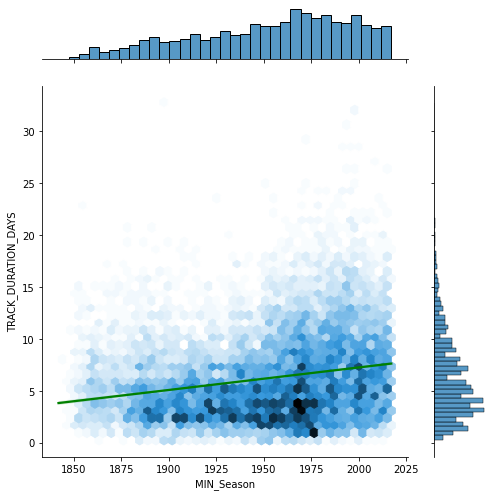

In [ ]:
jgrid = sns.jointplot(x='MIN_Season', y='TRACK_DURATION_DAYS', data=hurricanes_ipl.reset_index(drop=True), kind='hex', height=7, space=0.5)

sns.regplot(
    x='MIN_Season', y='TRACK_DURATION_DAYS', data=hurricanes_ipl, ax=jgrid.ax_joint, color='green', scatter=False
)

At a global scale, you can see an increase in the duration of hurricanes over time. Below, you wil split this up by basins to get a finer look.

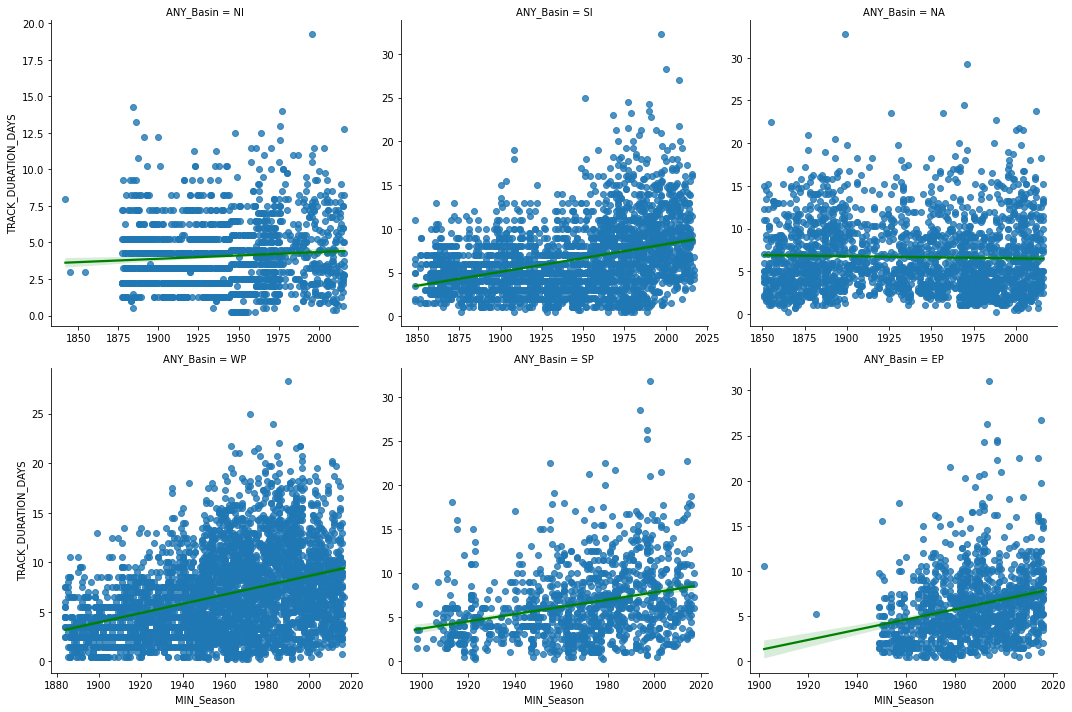

In [ ]:
lgrid = sns.lmplot('MIN_Season', 'TRACK_DURATION_DAYS', col='ANY_Basin', 
                   data=hurricanes_major_basins_df, col_wrap=3,
                   sharex=False, sharey=False, line_kws={'color':'green'})

In [ ]:
linger_time_corr_df = correlate_by_basin('MIN_Season','TRACK_DURATION_DAYS')
print('Correlation coefficients for MIN_Season vs TRACK_DURATION_DAYS')
linger_time_corr_df

Correlation coefficients for MIN_Season vs TRACK_DURATION_DAYS


,pearson-r,p-value
NI,0.0736,0.0034
SI,0.3585,0.0000
NA,-0.0295,0.1738
WP,0.3782,0.0000
SP,0.2795,0.0000
EP,0.2532,0.0000


For most basins, you will notice a positive trend in hurricane track duration. An exception to this is the **North Atlantic** basin where the `p-value` is not significant enough to let us draw any conclusion.

The trend you see here could be partly due to technological advancements that allow us to identify and track hurricanes at a very early stage. Hence, to complement this, you will analyze if hurricanes travel longer than usual once they make a landfall.

## Do hurricanes travel longer inland over time?
Along the lines of track duration, it is relevant for to investigate whether hurricanes travel longer inland over time.

Execute the cells below to examine the correlation of the track length of hurricanes over land against seasons.

Text(0.5, 1.0, 'Do hurricanes travel longer inland over time?')

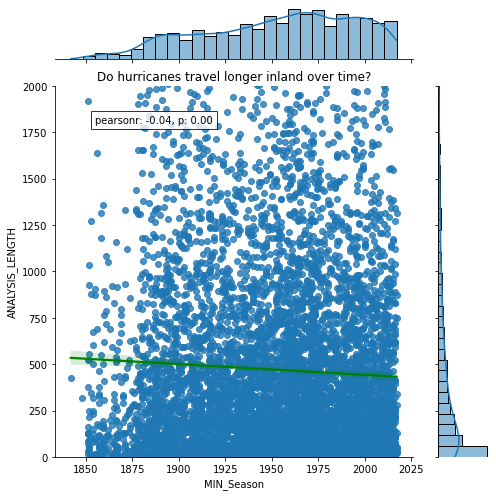

In [ ]:
jgrid = sns.jointplot(x='MIN_Season', y='ANALYSIS_LENGTH', data=hurricane_landfall_tracks_sdf,
                      kind='reg', joint_kws={'line_kws':{'color':'green'}}, 
                      height=7, space=0.5, ylim=[0,2000])

r, p = get_pearsonr(hurricane_landfall_tracks_sdf, 'MIN_Season', 'ANALYSIS_LENGTH')

jgrid.ax_joint.text(x=1855, y=1800, s="pearsonr: {:.2f}, p: {:.2f}".format(r, p), bbox=dict(facecolor='white', alpha=0.8))
jgrid.ax_joint.set_title('Do hurricanes travel longer inland over time?')

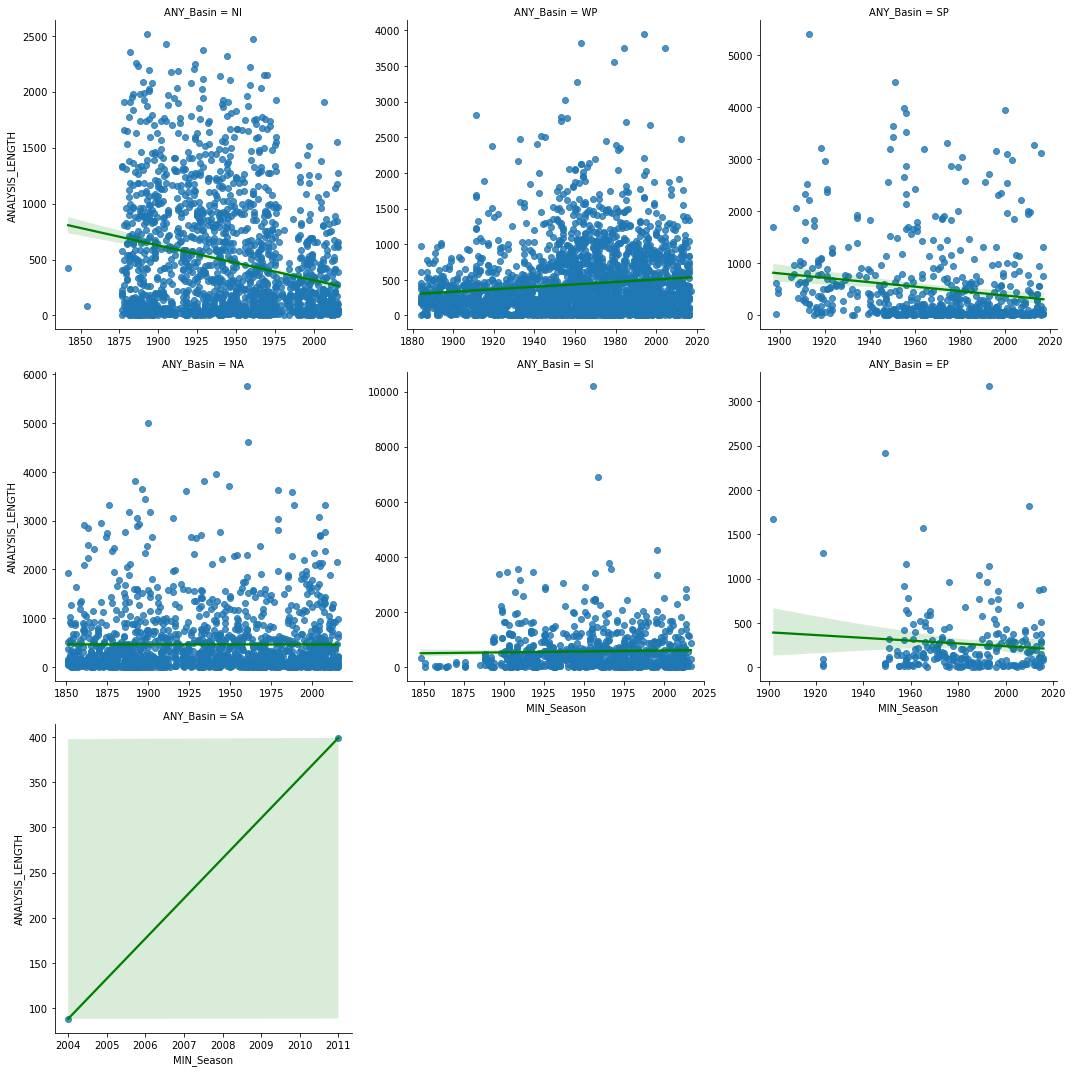

In [ ]:
lgrid = sns.lmplot('MIN_Season', 'ANALYSIS_LENGTH', col='ANY_Basin', data=hurricane_landfall_tracks_sdf, col_wrap=3,
                   sharex=False, sharey=False, line_kws={'color':'green'})

In [ ]:
linger_distance_corr_df = correlate_by_basin('MIN_Season','ANALYSIS_LENGTH', df=hurricane_landfall_tracks_sdf)
print('Correlation coefficients for MIN_Season vs inland track length')
linger_distance_corr_df

Correlation coefficients for MIN_Season vs inland track length


,pearson-r,p-value
NI,-0.2393,0.0000
WP,0.1246,0.0000
SP,-0.1571,0.0001
NA,-0.0006,0.9800
SI,0.0323,0.3343
EP,-0.0887,0.1780
SA,1.0000,1.0000


When inland track length is correlated over time, you can observe basins where the correlation is statistically significant.  The correlation is negative in the **North Indian** and **South Pacific**, though positive in **Western Pacific**. Thus while the duration of hurricanes continues to increase (due to reasons discussed previously), in at least two major basons hurricanes are tending to travel shorter distances inland. This could be problematic for communities affected, as the hurricane could remain stagnant and produce stronger than usual storm surges and precipitation.

## Correlate observations over time
Execute the cell below to collect all trend analysis performed so far into a single `DataFrame`.

In [ ]:
correlations_df = pd.DataFrame(index=wind_corr_df.index)
correlations_df["Max Wind Speed"] = wind_corr_df[wind_corr_df["p-value"] <= 0.05]['pearson-r']
correlations_df["Max Category"] = category_corr_df[category_corr_df["p-value"] <= 0.05]['pearson-r']
correlations_df["Linger Duration"] = linger_time_corr_df[linger_time_corr_df["p-value"] <= 0.05]['pearson-r']
correlations_df["Linger Distance"] = linger_distance_corr_df[linger_distance_corr_df["p-value"] <= 0.05]['pearson-r']
correlations_df["Max Pressure"] = pressure_corr_df[pressure_corr_df["p-value"] <= 0.05]['pearson-r']

correlations_df

,Max Wind Speed,Max Category,Linger Duration,Linger Distance,Max Pressure
NI,0.0617,0.5085,0.0736,-0.2393,0.0620
SI,0.0895,0.4185,0.3585,NaN,-0.1679
NA,-0.1075,0.2185,NaN,NaN,NaN
WP,0.1210,0.1627,0.3782,0.1246,-0.1581
SP,0.3519,0.3399,0.2795,-0.1571,-0.3210
EP,0.1114,0.2875,0.2532,NaN,0.1146


You can visualize this correlation table as a heat map to appreciate how the hurricane severity indicators correlate over seasons for each basin.  In resulting plot, you can see that there tend to be positive correlations over time for wind speed, category, and linger duration, while there tend to be consistent negative correlations over time for linger distance and eye pressure.

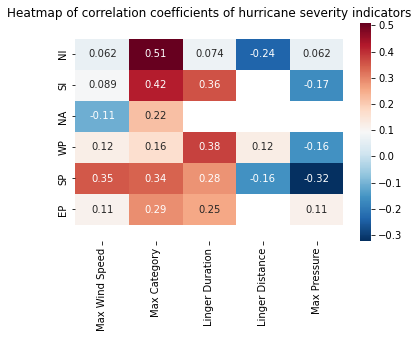

In [ ]:
hm_plot = sns.heatmap(correlations_df, annot=True, linecolor='black', cmap='RdBu_r')
hm_plot.set_title('Heatmap of correlation coefficients of hurricane severity indicators')

# Fix an issue with padding for top and bottom cells (https://github.com/mwaskom/seaborn/issues/1773)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da

## Conclusion
In this notebook you used the aggregated hurricane tracks produced in Part 1 and the landfall tracks layer produced in Part 2. You checked for missing sensor observations and imputed those records via interpolation. You then comprehensively analyzed how hurricane severity indicators such as **wind speed**, **atmospheric pressure**, **track duration**, **track length inland** and **category** correlate over time (seasons). You observed that the total number of hurricanes have decreased since the `1970`s globally and across all basins. While the number of hurricanes is decreasing, you observed that their wind speed, track duration, and category **correlate positively**, while the atmospheric pressure **correlates negatively**, against seasons. This aligns with findings from major studies. Thus, you noticed a reduction in the number of category 1 and 2, and an increase in the number of category 4 and 5 hurricanes.

In this study, through a 3-part series of notebooks, you learned how to download hurricane data for the past `176` years from the NOAA NEIC site over FTP, and how to interact with it initially using Pandas. Since the dataset is large and consists of many files, you learned how to read the data and aggregate columns using the Dask distributed/delayed processing library. You input the result of the processing using Dask into the ArcGIS Pro GeoAnalytics tools to aggregate these point observations into hurricane tracks. The "reconstruct tracks" tool which performed this aggregation identified `12,757` individual hurricanes across the globe.

In the second notebook, you performed comprehensive visualization and exploratory analysis to understand the geography of hurricanes and the various basins they are categorized into. You observed a sinusoidal nature to hurricane frequency, where hurricanes in the northern and southern hemispheres are offset by `6` months. You noticed certain names (e.g, `IRMA`, `JUNE`, `FLORENCE`) are more popular than the rest. You overlaid the tracks over land a boundary dataset to compute the tracks that traveled inland and to identify places where landfalls occur. Through density analysis of the landfall locations, you were able to identify the places that were most affected from a repeat landfall basis. By geo-enriching these places, you found  locations along the cost of **India** and **China** that are home to populations that are most affected by frequent hurricane landfalls.

Many studies and articles [[5]](https://www.theguardian.com/environment/2018/oct/08/global-warming-must-not-exceed-15c-warns-landmark-un-report) [[6]](https://www.vox.com/2018/10/9/17951924/climate-change-global-warming-un-ipcc-report-takeaways) [[7]](https://www.vox.com/energy-and-environment/2018/10/3/17925470/hurricane-florence-2018-devastation-climate-change-flood-sea-level-rise) [[8]](https://fivethirtyeight.com/features/how-climate-change-made-our-hurricane-predictions-way-more-accurate/) shine light on anthropogenic influences on global Sea Surface Temperature (SST). Higher sea surface temperatures are observed to produce more intense storms. They are attributed to polar ice cap melting and rising sea levels. When combined with increased hurricane intensity, these can lead to severe storm surges causing increased flooding and damage of the coastal communities. Based on our density and geoenrichment analysis, you observed that these are places along the coast that are densely populated.

This study showcases how a comprehensive spatial data science project can be performed using ArcGIS and open source Python libraries in an ArcGIS Notebook. The notebook medium makes it convenient to create a document that contains code, narrative, and graphics in one place. This helps make research reproducible and approachable. For example, in this study, you were able to empirically validate the conclusions derived by other studies, while presenting the exact methods you used in Python code, allowing others to review the work and verify the conclusions. In the future, when more hurricane datasets become available, this study can be repeated by re-running and adapting these notebooks.

#### References
 - [1. Recent intense hurricane response to global climate change. Holland, G. & Bruyère, C.L. Clim Dyn (2014) 42: 617.](https://doi.org/10.1007/s00382-013-1713-0)
 - [2. US Hurricane Clustering: A New Reality?](https://bankunderground.co.uk/2018/05/22/us-hurricane-clustering-a-new-reality/)
 - [3. Increasing destructiveness of tropical cyclones over the past 30 years](https://www.nature.com/articles/nature03906)
 - [4. The Hurricanes, and Climate-Change Questions, Keep Coming. Yes, They’re Linked. ](https://www.nytimes.com/2018/10/10/climate/hurricane-michael-climate-change.html)
 - [5. We have 12 years to limit climate change catastrophe, warns UN ](https://www.theguardian.com/environment/2018/oct/08/global-warming-must-not-exceed-15c-warns-landmark-un-report)
 - [6. Four big takeaways from the UN’s alarming climate change report](https://www.vox.com/2018/10/9/17951924/climate-change-global-warming-un-ipcc-report-takeaways)
 - [7. Hurricane Florence caused up to 22 billion in damages. Climate change made the storm worse.](https://www.vox.com/energy-and-environment/2018/10/3/17925470/hurricane-florence-2018-devastation-climate-change-flood-sea-level-rise)
 - [8. What Climate Change Taught Us About Hurricanes ](https://fivethirtyeight.com/features/how-climate-change-made-our-hurricane-predictions-way-more-accurate/)